<a href="https://colab.research.google.com/github/sebiyang/Trends-in-the-global-game-market/blob/main/AI_13_%EC%96%91%EC%84%B8%EB%B9%84_section2_project_zip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**<카드사의 소비자 별 마켓팅 전략 수립>**

1. 어떤 소비자들은 주로 무엇을 구매하며, 어떤 쿠폰을 이용하는가? (EDA)

2. 소비자들의 구매 형태 / 쿠폰 이용 형태가 군집의 형태를 띄는가? 집단별 속성은 어떠한가? (k-means clustering)

3. 소비자 분류기 만들기 (분류)

-사용 데이터 : https://www.kaggle.com/datasets/vasudeva009/predicting-coupon-redemption-smote

##1.데이터 전처리 

In [1]:
import pandas as pd
campaign = pd.read_csv("/content/drive/MyDrive/Codestates/section2 project/dataset/campaign_data.csv")

In [2]:
cupon = pd.read_csv("/content/drive/MyDrive/Codestates/section2 project/dataset/coupon_item_mapping.csv")
customer_demo =  pd.read_csv("/content/drive/MyDrive/Codestates/section2 project/dataset/customer_demographics.csv")
customer =pd.read_csv("/content/drive/MyDrive/Codestates/section2 project/dataset/customer_transaction_data.csv")

In [3]:
item =pd.read_csv("/content/drive/MyDrive/Codestates/section2 project/dataset/item_data.csv")

In [4]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [5]:
cupon.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


In [6]:
customer_demo.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [7]:
customer.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [8]:
customer_merged= customer.merge(customer_demo, how = "left", on ="customer_id")

In [9]:
customer_merged.isnull().sum()

date                     0
customer_id              0
item_id                  0
quantity                 0
selling_price            0
other_discount           0
coupon_discount          0
age_range           532964
marital_status      863267
rented              532964
family_size         532964
no_of_children     1054199
income_bracket      532964
dtype: int64

전체 데이터 중 소비자 정보에 대한 데이터의 결측치 비중이 아주 높음. 13만개의 데이터셋 중, 30~80% 가까이 데이터가 비어있었음. 

-이런 경우, 데이터셋들 자체를 이용하여 연역을 통해 임의의 값으로 결측치를 채울 수 있음

-해당 데이터셋에서 'no_of_childeren' 과 'family_size' 셋 두가지를 이용해 연역적 추론을 진행함 

In [10]:
customer_merged['no_of_children'].value_counts()

1     121467
3+     74592
2      74308
Name: no_of_children, dtype: int64

In [11]:
customer_merged['family_size'].value_counts()

2     304391
1     232968
3     122796
5+     69359
4      62088
Name: family_size, dtype: int64

In [12]:
#아이 수를 모르는데 가족 수가 1명이면 아이는 없는것으로 처리 
customer_merged.loc[customer_merged['no_of_children'].isnull() & customer_merged['family_size'] == 1, 'no_of_children'] = 0

In [13]:
customer_merged['no_of_children'].isnull().sum()

532964

In [14]:
#결혼 여부를 모르는데 가족 수가 1명이면 Single 로 처리 
customer_merged.loc[customer_merged['marital_status'].isnull() & customer_merged['family_size'] == 1, 'marital_status'] = "Single"

In [15]:
customer_merged['marital_status'].isnull().sum()

532964

In [16]:
#추론을 통한 처리가 완료된 결측치, 전체의 40% 가량의 소비자가 개인정보를 입력하지 않음. 
#임의로 채우거나, 개인정보 없이 인사이트를 얻어내는 것이 불가능하기 때문에 과감히 삭제 
customer_merged.isnull().sum()

date                    0
customer_id             0
item_id                 0
quantity                0
selling_price           0
other_discount          0
coupon_discount         0
age_range          532964
marital_status     532964
rented             532964
family_size        532964
no_of_children     532964
income_bracket     532964
dtype: int64

In [17]:
customer_dropna = customer_merged.dropna(axis=0)

In [18]:
customer_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 791602 entries, 6 to 1324565
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   date             791602 non-null  object 
 1   customer_id      791602 non-null  int64  
 2   item_id          791602 non-null  int64  
 3   quantity         791602 non-null  int64  
 4   selling_price    791602 non-null  float64
 5   other_discount   791602 non-null  float64
 6   coupon_discount  791602 non-null  float64
 7   age_range        791602 non-null  object 
 8   marital_status   791602 non-null  object 
 9   rented           791602 non-null  float64
 10  family_size      791602 non-null  object 
 11  no_of_children   791602 non-null  object 
 12  income_bracket   791602 non-null  float64
dtypes: float64(5), int64(3), object(5)
memory usage: 84.6+ MB


In [19]:
item.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [20]:
#구매품목 정보와 소비자 정보 결합
customer_item= customer_dropna.merge(item, how = "inner", on ="item_id")
customer_item.head()

#소비자 정보와 쿠폰 정보 결합 
customer_fin= customer_item.merge(cupon, how = "inner", on ="item_id")
customer_fin.info()
customer_fin.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1261773 entries, 0 to 1261772
Data columns (total 17 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   date             1261773 non-null  object 
 1   customer_id      1261773 non-null  int64  
 2   item_id          1261773 non-null  int64  
 3   quantity         1261773 non-null  int64  
 4   selling_price    1261773 non-null  float64
 5   other_discount   1261773 non-null  float64
 6   coupon_discount  1261773 non-null  float64
 7   age_range        1261773 non-null  object 
 8   marital_status   1261773 non-null  object 
 9   rented           1261773 non-null  float64
 10  family_size      1261773 non-null  object 
 11  no_of_children   1261773 non-null  object 
 12  income_bracket   1261773 non-null  float64
 13  brand            1261773 non-null  int64  
 14  brand_type       1261773 non-null  object 
 15  category         1261773 non-null  object 
 16  coupon_id        1

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,age_range,marital_status,rented,family_size,no_of_children,income_bracket,brand,brand_type,category,coupon_id
0,2012-01-02,857,14930,1,110.07,0.00,0.0,70+,Single,0.0,1,0,7.0,3235,Established,Meat,24
1,2012-01-02,857,14930,1,110.07,0.00,0.0,70+,Single,0.0,1,0,7.0,3235,Established,Meat,8
2,2012-01-02,857,14930,1,110.07,0.00,0.0,70+,Single,0.0,1,0,7.0,3235,Established,Meat,33
3,2012-01-02,857,16657,1,89.05,-35.26,0.0,70+,Single,0.0,1,0,7.0,2011,Established,Packaged Meat,24
4,2012-01-02,857,16657,1,89.05,-35.26,0.0,70+,Single,0.0,1,0,7.0,2011,Established,Packaged Meat,8


In [21]:
customer_fin.tail()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,age_range,marital_status,rented,family_size,no_of_children,income_bracket,brand,brand_type,category,coupon_id
1261768,2013-06-30,1129,2423,1,81.57,-7.12,0.0,70+,Single,0.0,2,0,9.0,56,Local,Grocery,211
1261769,2013-06-30,1129,2423,1,81.57,-7.12,0.0,70+,Single,0.0,2,0,9.0,56,Local,Grocery,30
1261770,2013-06-30,1129,2777,1,284.60,-71.24,0.0,70+,Single,0.0,2,0,9.0,2074,Established,Grocery,43
1261771,2013-06-30,1129,2777,1,284.60,-71.24,0.0,70+,Single,0.0,2,0,9.0,2074,Established,Grocery,42
1261772,2013-06-30,1129,2777,1,284.60,-71.24,0.0,70+,Single,0.0,2,0,9.0,2074,Established,Grocery,1084


In [22]:
customer_fin = customer_fin.drop(["item_id","brand"],axis=1)

In [23]:
import datetime as datetime

customer_fin['date']=pd.to_datetime(customer_fin['date'],  format="%Y-%m-%d")

In [24]:
customer_fin['Month'] = customer_fin['date'].dt.month 

In [25]:
import seaborn as sns

##2.EDA

In [26]:
group = customer_fin.groupby('Month').sum().reset_index()
group.head()

,Month,customer_id,quantity,selling_price,other_discount,coupon_discount,rented,income_bracket,coupon_id
0,1,74814586,120367,9973379.71,-2080252.60,-75375.19,5122.0,457815.0,18554033
1,2,81269004,130723,10793400.29,-2224398.57,-86183.40,6296.0,495465.0,19536698
2,3,99883869,162405,13510306.59,-2871624.29,-108949.21,7984.0,605385.0,24366009
3,4,111630467,182451,14831285.59,-3231419.73,-100781.27,9103.0,681984.0,27187140
4,5,125926495,204502,16544767.08,-3440533.57,-101607.50,9723.0,766270.0,30439160


Text(0.5, 1.0, 'Monthly purchace quantity')

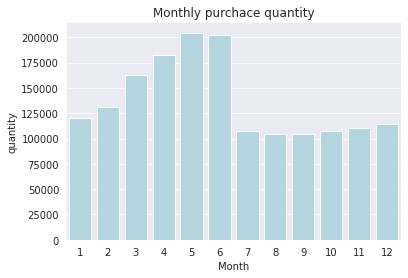

In [28]:
#월별 구매량 
sns.set_style('darkgrid')
q= sns.barplot(x=group['Month'],y=group['quantity'],color="lightblue")
q.set_title("Monthly purchace quantity")

In [29]:
group2 = customer_fin.groupby('Month').count().reset_index()
group2.head()

,Month,date,customer_id,quantity,selling_price,other_discount,coupon_discount,age_range,marital_status,rented,family_size,no_of_children,income_bracket,brand_type,category,coupon_id
0,1,92614,92614,92614,92614,92614,92614,92614,92614,92614,92614,92614,92614,92614,92614,92614
1,2,100382,100382,100382,100382,100382,100382,100382,100382,100382,100382,100382,100382,100382,100382,100382
2,3,124162,124162,124162,124162,124162,124162,124162,124162,124162,124162,124162,124162,124162,124162,124162
3,4,139767,139767,139767,139767,139767,139767,139767,139767,139767,139767,139767,139767,139767,139767,139767
4,5,156457,156457,156457,156457,156457,156457,156457,156457,156457,156457,156457,156457,156457,156457,156457


Text(0.5, 1.0, 'Monthly cupon discount ratio')

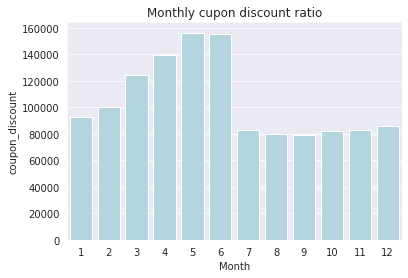

In [30]:
c= sns.barplot(x=group2['Month'],y=group2['coupon_discount'],color="lightblue")
c.set_title("Monthly cupon discount ratio")

In [31]:
group3 = customer_fin.groupby('customer_id').sum().reset_index()
group3 = customer_fin.groupby('age_range').sum().reset_index()
group3.head()

,age_range,customer_id,quantity,selling_price,other_discount,coupon_discount,rented,income_bracket,coupon_id,Month
0,18-25,60879398,95585,7283533.36,-1473517.54,-29710.80,14227.0,277995.0,13437729,426038
1,26-35,183667469,283687,23653192.95,-4462168.95,-165838.94,16861.0,1103568.0,46476111,1364991
2,36-45,276779722,466647,37662603.83,-8041035.93,-300789.98,26877.0,1797672.0,70387779,2096549
3,46-55,371482811,586999,48607489.90,-10312661.50,-387686.50,17787.0,2279332.0,87216898,2735905
4,56-70,56383684,110203,8986399.31,-2091059.48,-82684.08,1954.0,408207.0,16953456,492275


Text(0.5, 1.0, 'Quantity of purcahcement by age range')

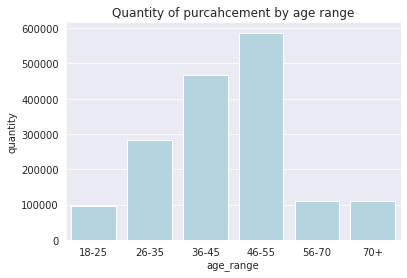

In [32]:
a= sns.barplot(x=group3['age_range'],y=group3['quantity'],color="lightblue")
a.set_title("Quantity of purcahcement by age range")

Text(0.5, 1.0, 'Quantity of cupon discount by age range')

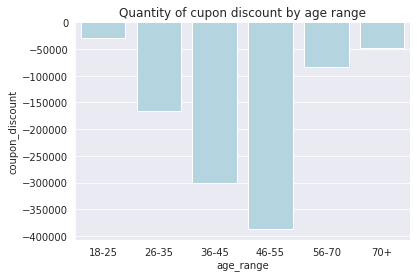

In [33]:
b= sns.barplot(x=group3['age_range'],y=group3['coupon_discount'],color="lightblue")
b.set_title("Quantity of cupon discount by age range")

##3.군집 

####3.1 추가 전처리 

In [34]:
customer_fin['sales_sum'] = customer_fin['selling_price'] * customer_fin['quantity']
customer_fin = customer_fin.drop(["quantity","selling_price","coupon_id"],axis=1)
customer_fin.head()

,date,customer_id,other_discount,coupon_discount,age_range,marital_status,rented,family_size,no_of_children,income_bracket,brand_type,category,Month,sales_sum
0,2012-01-02,857,0.00,0.0,70+,Single,0.0,1,0,7.0,Established,Meat,1,110.07
1,2012-01-02,857,0.00,0.0,70+,Single,0.0,1,0,7.0,Established,Meat,1,110.07
2,2012-01-02,857,0.00,0.0,70+,Single,0.0,1,0,7.0,Established,Meat,1,110.07
3,2012-01-02,857,-35.26,0.0,70+,Single,0.0,1,0,7.0,Established,Packaged Meat,1,89.05
4,2012-01-02,857,-35.26,0.0,70+,Single,0.0,1,0,7.0,Established,Packaged Meat,1,89.05


In [35]:
customer_encoded = pd.get_dummies(customer_fin)
customer_encoded.head()

,date,customer_id,other_discount,coupon_discount,rented,income_bracket,Month,sales_sum,age_range_18-25,age_range_26-35,...,category_Miscellaneous,category_Natural Products,category_Packaged Meat,category_Pharmaceutical,category_Prepared Food,category_Salads,category_Seafood,category_Skin & Hair Care,category_Travel,category_Vegetables (cut)
0,2012-01-02,857,0.00,0.0,0.0,7.0,1,110.07,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2012-01-02,857,0.00,0.0,0.0,7.0,1,110.07,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2012-01-02,857,0.00,0.0,0.0,7.0,1,110.07,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-01-02,857,-35.26,0.0,0.0,7.0,1,89.05,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2012-01-02,857,-35.26,0.0,0.0,7.0,1,89.05,0,0,...,0,0,1,0,0,0,0,0,0,0


####3.2. 엘보우 메서드

k: 2 | cost: 228671013638.4617
k: 3 | cost: 154450862150.5793
k: 4 | cost: 93438696006.9793
k: 5 | cost: 60814830876.553154
k: 6 | cost: 46125419994.00405


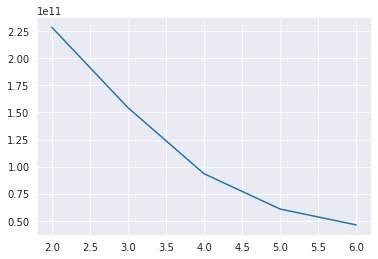

In [36]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# K-means train & Elbow method
X = customer_encoded[['rented', 'income_bracket','sales_sum','age_range_18-25',
       'age_range_26-35', 'age_range_36-45', 'age_range_46-55',
       'age_range_56-70', 'age_range_70+','marital_status_Married',
       'marital_status_Single', 'family_size_1', 'family_size_2',
       'family_size_3', 'family_size_4', 'family_size_5+', 'no_of_children_0',
       'no_of_children_1', 'no_of_children_2', 'no_of_children_3+','brand_type_Established', 'brand_type_Local', 'category_Bakery',
       'category_Dairy, Juices & Snacks', 'category_Flowers & Plants',
       'category_Garden', 'category_Grocery', 'category_Meat',
       'category_Miscellaneous', 'category_Natural Products',
       'category_Packaged Meat', 'category_Pharmaceutical',
       'category_Prepared Food', 'category_Salads', 'category_Seafood',
       'category_Skin & Hair Care', 'category_Travel',
       'category_Vegetables (cut)']]

k_list = []
cost_list = []
for k in range (2, 7):
    kmeans = KMeans(n_clusters=k).fit(X)
    interia = kmeans.inertia_
    print ("k:", k, "| cost:", interia)
    k_list.append(k)
    cost_list.append(interia)
    
plt.plot(k_list, cost_list)

###3.3.군집분석 

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# selected by elbow method (5)
kmeans = KMeans(n_clusters=5, algorithm="elkan").fit(X)

cluster_num = kmeans.predict(X)

cluster = pd.Series(cluster_num)
customer_encoded['cluster_num'] = cluster.values
customer_encoded.head()

,date,customer_id,other_discount,coupon_discount,rented,income_bracket,Month,sales_sum,age_range_18-25,age_range_26-35,...,category_Natural Products,category_Packaged Meat,category_Pharmaceutical,category_Prepared Food,category_Salads,category_Seafood,category_Skin & Hair Care,category_Travel,category_Vegetables (cut),cluster_num
0,2012-01-02,857,0.00,0.0,0.0,7.0,1,110.07,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2012-01-02,857,0.00,0.0,0.0,7.0,1,110.07,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2012-01-02,857,0.00,0.0,0.0,7.0,1,110.07,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-01-02,857,-35.26,0.0,0.0,7.0,1,89.05,0,0,...,0,1,0,0,0,0,0,0,0,0
4,2012-01-02,857,-35.26,0.0,0.0,7.0,1,89.05,0,0,...,0,1,0,0,0,0,0,0,0,0


###3.4. 분류된 군집별 특성 추출 

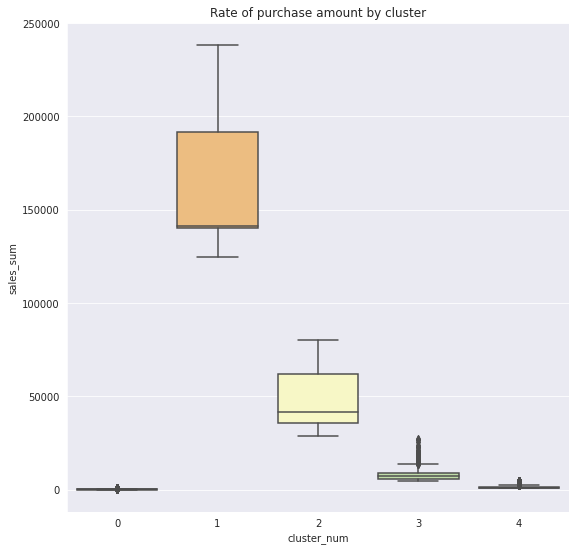

In [38]:
fig = plt.figure(figsize = (9, 9))
ax = fig.gca()
sales = sns.boxplot(x = "cluster_num", y = "sales_sum", data=customer_encoded, ax=ax, palette = 'Spectral')
sales.set_title("Rate of purchase amount by cluster")
plt.show()

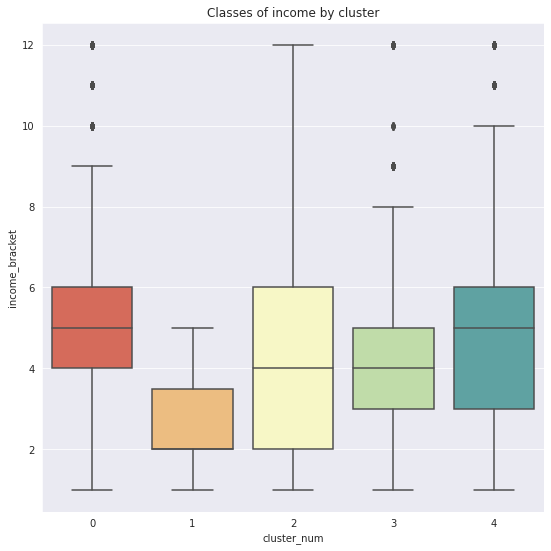

In [39]:
fig = plt.figure(figsize = (9, 9))
ax = fig.gca()
income = sns.boxplot(x = "cluster_num", y = "income_bracket", data=customer_encoded, ax=ax,palette = 'Spectral')
income.set_title("Classes of income by cluster")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

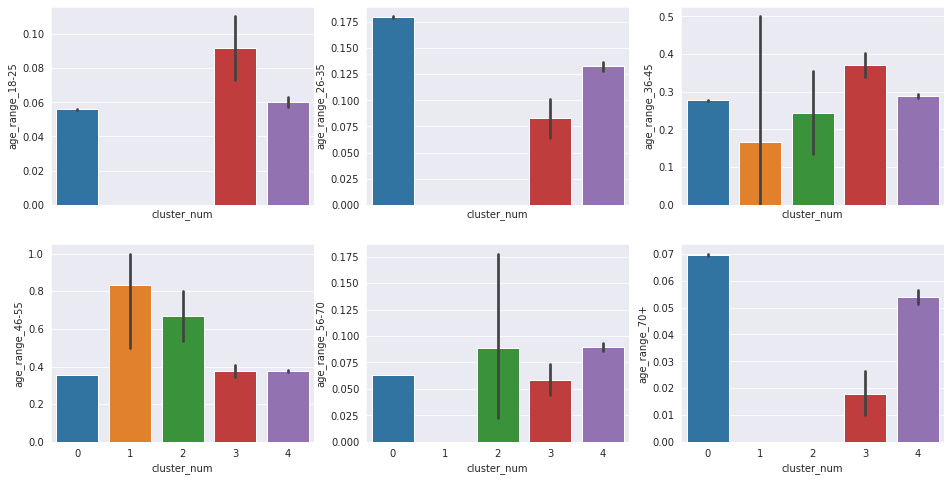

In [40]:
fig, ax = plt.subplots(2,3,sharex=True, figsize=(16,8))
sns.barplot("cluster_num", 'age_range_18-25', data=customer_encoded, ax=ax[0,0])
sns.barplot("cluster_num", 'age_range_26-35', data=customer_encoded, ax=ax[0,1])
sns.barplot("cluster_num", 'age_range_36-45', data=customer_encoded, ax=ax[0,2])
sns.barplot("cluster_num", 'age_range_46-55', data=customer_encoded, ax=ax[1,0])
sns.barplot("cluster_num", 'age_range_56-70', data=customer_encoded, ax=ax[1,1])
sns.barplot("cluster_num", 'age_range_70+', data=customer_encoded, ax=ax[1,2])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


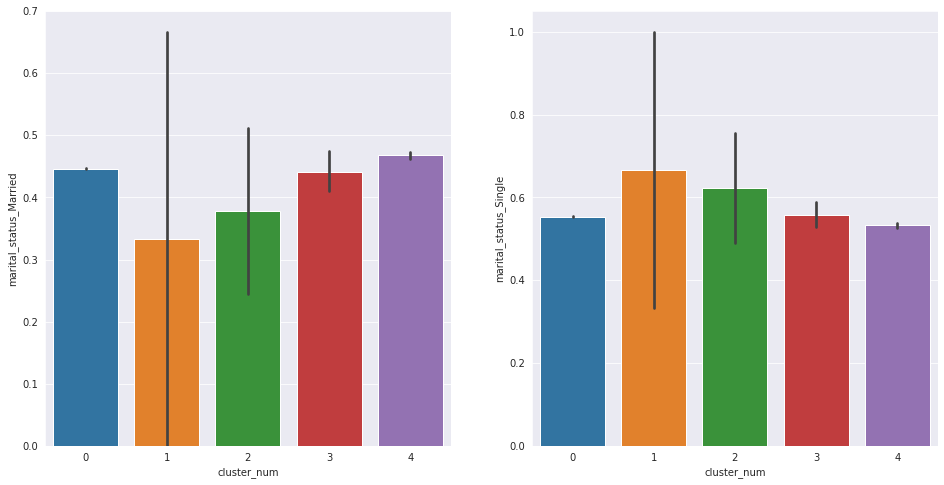

In [41]:
fig, ax = plt.subplots(1,2,sharex=True, figsize=(16,8))
sns.barplot("cluster_num", 'marital_status_Married', data=customer_encoded, ax=ax[0])
sns.barplot("cluster_num",  'marital_status_Single', data=customer_encoded, ax=ax[1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

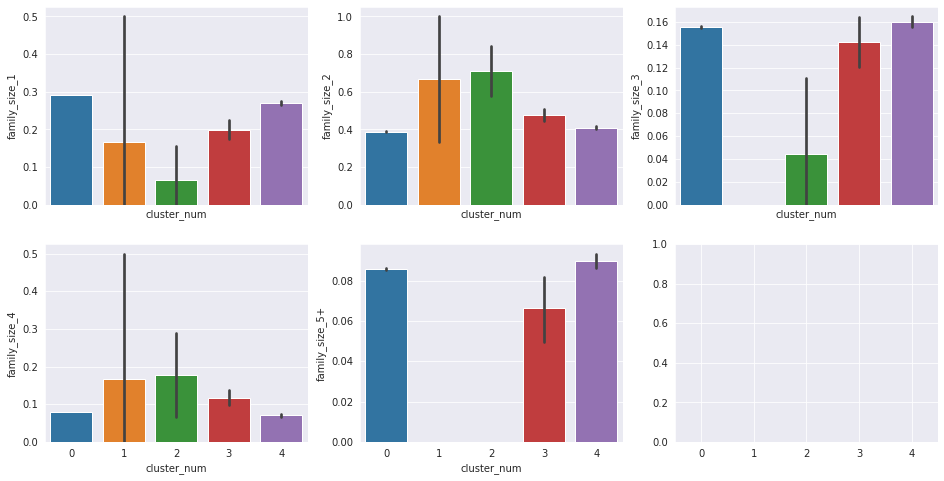

In [42]:
fig, ax = plt.subplots(2,3,sharex=True, figsize=(16,8))
sns.barplot("cluster_num", 'family_size_1', data=customer_encoded, ax=ax[0,0])
sns.barplot("cluster_num", 'family_size_2', data=customer_encoded, ax=ax[0,1])
sns.barplot("cluster_num", 'family_size_3', data=customer_encoded, ax=ax[0,2])
sns.barplot("cluster_num", 'family_size_4', data=customer_encoded, ax=ax[1,0])
sns.barplot("cluster_num", 'family_size_5+', data=customer_encoded, ax=ax[1,1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


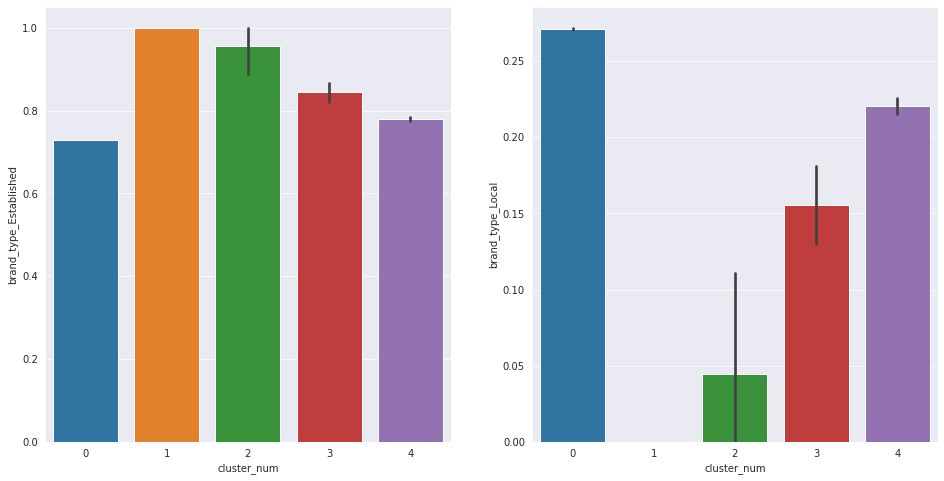

In [43]:
fig, ax = plt.subplots(1,2,sharex=True, figsize=(16,8))
sns.barplot("cluster_num", 'brand_type_Established', data=customer_encoded, ax=ax[0])
sns.barplot("cluster_num",'brand_type_Local', data=customer_encoded, ax=ax[1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

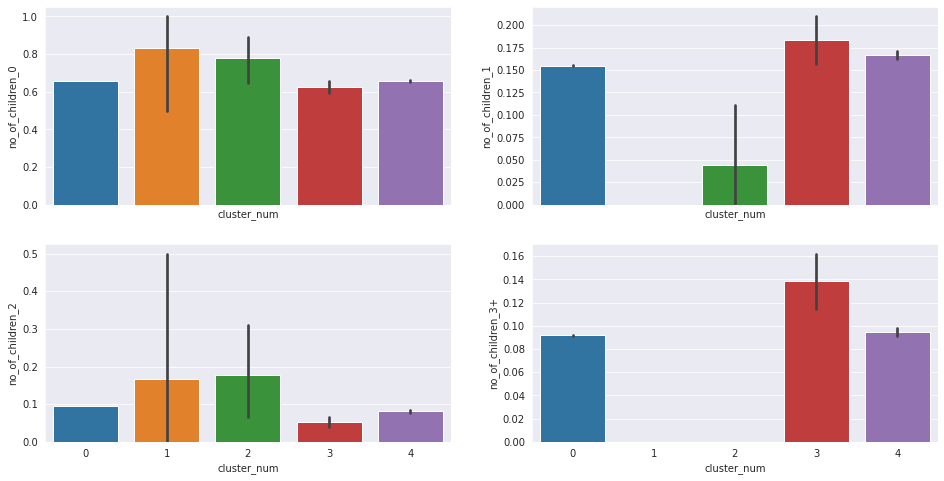

In [44]:
fig, ax = plt.subplots(2,2,sharex=True, figsize=(16,8))
sns.barplot("cluster_num", 'no_of_children_0', data=customer_encoded, ax=ax[0,0])
sns.barplot("cluster_num", 'no_of_children_1', data=customer_encoded, ax=ax[0,1])
sns.barplot("cluster_num", 'no_of_children_2', data=customer_encoded, ax=ax[1,0])
sns.barplot("cluster_num", 'no_of_children_3+', data=customer_encoded, ax=ax[1,1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

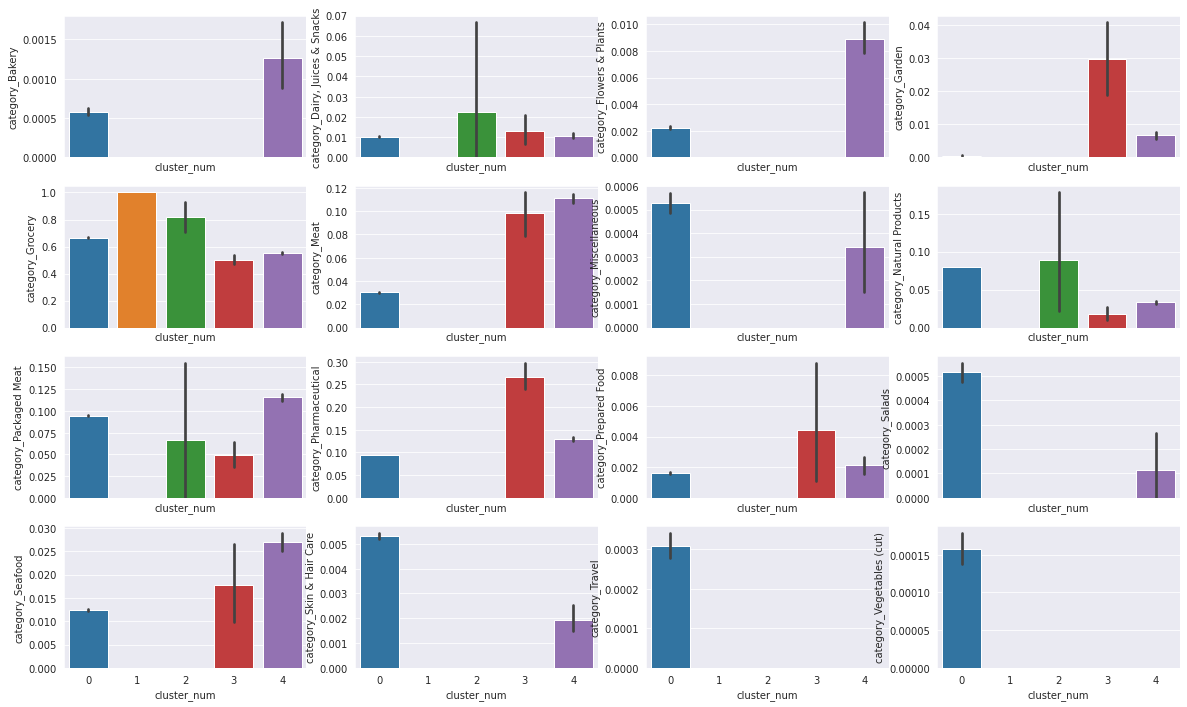

In [45]:
fig, ax = plt.subplots(4,4,sharex=True, figsize=(22,14))
sns.barplot("cluster_num", 'category_Bakery', data=customer_encoded, ax=ax[0,0])
sns.barplot("cluster_num", 'category_Dairy, Juices & Snacks', data=customer_encoded, ax=ax[0,1])
sns.barplot("cluster_num", 'category_Flowers & Plants', data=customer_encoded, ax=ax[0,2])
sns.barplot("cluster_num", 'category_Garden', data=customer_encoded, ax=ax[0,3])
sns.barplot("cluster_num", 'category_Grocery', data=customer_encoded, ax=ax[1,0])
sns.barplot("cluster_num", 'category_Meat', data=customer_encoded, ax=ax[1,1])
sns.barplot("cluster_num", 'category_Miscellaneous', data=customer_encoded, ax=ax[1,2])
sns.barplot("cluster_num", 'category_Natural Products', data=customer_encoded, ax=ax[1,3])
sns.barplot("cluster_num", 'category_Packaged Meat', data=customer_encoded, ax=ax[2,0])
sns.barplot("cluster_num", 'category_Pharmaceutical', data=customer_encoded, ax=ax[2,1])
sns.barplot("cluster_num", 'category_Prepared Food', data=customer_encoded, ax=ax[2,2])
sns.barplot("cluster_num", 'category_Salads', data=customer_encoded, ax=ax[2,3])
sns.barplot("cluster_num", 'category_Seafood', data=customer_encoded, ax=ax[3,0])
sns.barplot("cluster_num", 'category_Skin & Hair Care', data=customer_encoded, ax=ax[3,1])
sns.barplot("cluster_num", 'category_Travel', data=customer_encoded, ax=ax[3,2])
sns.barplot("cluster_num", 'category_Vegetables (cut)', data=customer_encoded, ax=ax[3,3])

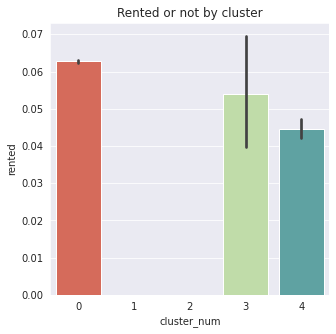

In [46]:
fig = plt.figure(figsize = (5, 5))
ax = fig.gca()
rent = sns.barplot(x = "cluster_num", y = "rented", data=customer_encoded, ax=ax, palette = 'Spectral')
rent.set_title("Rented or not by cluster")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


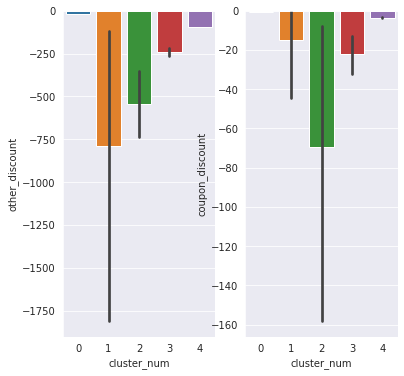

In [47]:
fig, ax = plt.subplots(1,2,sharex=True, figsize=(6,6))
sns.barplot("cluster_num", 'other_discount', data=customer_encoded, ax=ax[0])
sns.barplot("cluster_num",'coupon_discount', data=customer_encoded, ax=ax[1])

-**Cluster 0** (가장 많은 집단 차지)

1. 중간치의 소득, 구매력이 높진 않음 
2. 연령대 분포는 70대 이상이 높았으며 결혼 유무는 영향을 받지 않음
3. 가족의 사이즈는 큰 편이었으며, local 제품의 구매력이 높았음
4. 여행, 헬스케어, 샐러드, 야채, 기타 잡다한 것들을 다른 집단보다 많이 구매함
5. 아이의 수는 다양함 

---->    **대가족의 노년층으로 추정**


-**Cluster 1** (쿠폰을 통해 가장 많이 할인받음)

1. 소득은 가장 낮았으나, 구매력은 가장 높았음 (rent 에 살고있음)
2. 35세에서 55세로만 이루어져 있었고, 주로 싱글이며 가족의 크기가 작았음
3. 프랜차이즈의 구매력이 아주 높았으며, 식품만을 구매한 집단임 
4. 아이가 가장 없는 집단임 


---->   **중년 1인가구로 추정**


-**Cluster 2*** (두번째로 많은 집단 차지)

1. 중하 수준의 소득, 구매력이 낮음 
2. 전 연령에 고르게 분포했으나, 20대 초반, 30대 후반의 비중이 가장 높음
3. 주로 혼인한 3인가구였으며,프랜차이즈와 로컬 제품 모두를 구매함
4. 해산물, 고기, 냉동식품, 의약품을 주로 구매함
5. 아이가 있는 집단일 확률이 높음


---->   **신혼부부로 추정**


-**Cluster3** (수가 너무 적어서 이상치로 간주) 

1. 2번째로 높은 구매력을 가졌으나, 소득 범주는 가장 넓음 (rent 에 살고있음)
2. 35세-70세 사이의 중년층의 집단임
3. 혼인 여부는 영향을 주지 않았고, 가족의 형태도 다양함
4. 프랜차이즈 제품을 조금 더 선호했으며, 식료품, 고기, 간식, 자연제품 등을 주로 구매함 
5. 보통 아이가 적게 있거나 없음


---->   **기혼 중장년층으로 추정**


-**Cluster 4** 

1. 중간 수준의 소득과 낮은 구매력을 가짐, 연령대는 가장 다양함
2. 주로 가족 구성원 수가 많은 것이 특징임 
3. 특별히 선호하는 브랜드나 제품군이 없고, 모두 골고루 구매하는것이 특징임 
4. 아이가 많은 집단일 확률이 높음 

---->   **가족 구성원의 수가 많은 집단으로 추정**

In [48]:
customer_encoded['cluster_num'].value_counts()

0    1234596
4      26220
3        906
2         45
1          6
Name: cluster_num, dtype: int64

#4 분류모델 

#####앞서 분류한 군집을 이용해 소비자를 5가지 군집으로 분류하는 분류모델을 만들고, 추후 신규 가입자가 생기면 분류기를 이용해 실시간으로 마켓팅 할 수 있게 함#####

####4.1 데이터 분리

In [50]:
customer_encoded.columns

Index(['date', 'customer_id', 'other_discount', 'coupon_discount', 'rented',
       'income_bracket', 'Month', 'sales_sum', 'age_range_18-25',
       'age_range_26-35', 'age_range_36-45', 'age_range_46-55',
       'age_range_56-70', 'age_range_70+', 'marital_status_Married',
       'marital_status_Single', 'family_size_1', 'family_size_2',
       'family_size_3', 'family_size_4', 'family_size_5+', 'no_of_children_0',
       'no_of_children_1', 'no_of_children_2', 'no_of_children_3+',
       'brand_type_Established', 'brand_type_Local', 'category_Bakery',
       'category_Dairy, Juices & Snacks', 'category_Flowers & Plants',
       'category_Garden', 'category_Grocery', 'category_Meat',
       'category_Miscellaneous', 'category_Natural Products',
       'category_Packaged Meat', 'category_Pharmaceutical',
       'category_Prepared Food', 'category_Salads', 'category_Seafood',
       'category_Skin & Hair Care', 'category_Travel',
       'category_Vegetables (cut)', 'cluster_num'],
    

In [51]:
customer_encoded = customer_encoded.drop(['date','customer_id','Month'],axis=1)

In [52]:
#타깃과 피쳐 지정

target = 'cluster_num'
features = customer_encoded.drop(columns=[target]).columns

In [53]:
# train/test 로 나누기
from sklearn.model_selection import train_test_split


train, test = train_test_split(customer_encoded, train_size=0.80, test_size=0.20, 
                              shuffle=False, random_state=2)

In [54]:
X_train = train[features]
y_train = train[target]
X_test= test[features]
y_test = test[target]

In [55]:
X_train.head()

,other_discount,coupon_discount,rented,income_bracket,sales_sum,age_range_18-25,age_range_26-35,age_range_36-45,age_range_46-55,age_range_56-70,...,category_Miscellaneous,category_Natural Products,category_Packaged Meat,category_Pharmaceutical,category_Prepared Food,category_Salads,category_Seafood,category_Skin & Hair Care,category_Travel,category_Vegetables (cut)
0,0.00,0.0,0.0,7.0,110.07,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.00,0.0,0.0,7.0,110.07,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.00,0.0,0.0,7.0,110.07,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-35.26,0.0,0.0,7.0,89.05,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,-35.26,0.0,0.0,7.0,89.05,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [56]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: cluster_num, dtype: int32

####4.2 기준모델 설정 

In [57]:
from sklearn.metrics import accuracy_score

#기준모델 만들기, 최빈값은 0

# 기준모델은 0으로 설정
p = [0]*len(y_test)

# y_val과 비교하여 정확도 구하기
base_accuracy = accuracy_score(y_test, p)
print(f'기준 모델의 정확도: {base_accuracy: .2f}')

기준 모델의 정확도:  0.98


####4.3. 다중분류

In [58]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

n_classes=5

multi = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                                     oob_score=True, random_state=42, 
                                                     min_samples_split=4
                                                     ,min_samples_leaf=1, max_depth=19))

k = 2
scores = cross_val_score(multi, X_train, y_train, cv=k, scoring='accuracy')

dists = {
    'estimator__min_samples_split': range(1,5),
    'estimator__max_depth': range(7,19),
    'estimator__min_samples_leaf': range(1,5)
}


clf = RandomizedSearchCV(
    multi, 
    param_distributions=dists, 
    n_iter=10, 
    cv=2,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train.values.reshape(-1, 1));

Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
2 fits failed out of a total of 2.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/multioutput.py", line 434, in fit
    super().fit(X, Y, sample_weight, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/multioutput.py", line 191, in fit
    "y must have at least two dimensions for "
ValueError: y must have at least two dimensio

In [59]:
predict_value = clf.predict(X_train)

In [60]:
predict_value=pd.DataFrame(predict_value)
predict_value.value_counts()

0    988545
4     20137
3       695
2        35
1         6
dtype: int64

####4.5.모델 평가

In [61]:
print('검증 정확도: ', clf.score(X_test, y_test))

#baseline 보다 높은 검증 정확도 

검증 정확도:  0.9999207465673356


In [62]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
predict = clf.predict(X_test)

precision_score = precision_score(y_test, predict, pos_label='positive',average='macro')
recall_score = recall_score(y_test, predict,pos_label='positive',average='macro')

print("Precision Score : ",precision_score)
print("Recall Score : ",recall_score)

Precision Score :  0.7379074500997774
Recall Score :  0.7417031129888862


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1375: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  UserWarning,


In [63]:
f1score = 2* (precision_score * recall_score )/ (precision_score + recall_score)
f1score

0.7398004130143526

In [ ]:
#다중분류에서는 Roc_Auc curve, f1score, confusion matrix 등의 metric 이 지원되지 않아 코드로 직접 구현했습니다

####4.6.모델 해석

*현재 Multi output classifier 에서는 각종 metrics 를 지원하지 않기 때문에 특성 중요도를 코드로 구현했습니다

In [66]:
n_classes=5

multi1 = MultiOutputClassifier(RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                                     oob_score=True, random_state=42, 
                                                     min_samples_split=4
                                                     ,min_samples_leaf=1, max_depth=19))


multi1.fit(X_train, y_train.values.reshape(-1, 1));

In [67]:
import numpy as np

feat_impts = [] 
for clf in multi1.estimators_:
    feat_impts.append(clf.feature_importances_)

np.mean(feat_impts, axis=0)

array([1.35354253e-01, 1.80506387e-02, 2.18593376e-03, 5.47534824e-02,
       6.05529052e-01, 4.33896733e-03, 5.55857710e-03, 1.52412485e-02,
       2.16732725e-02, 3.04502862e-03, 2.23815540e-03, 9.51278138e-03,
       9.31713812e-03, 8.27117179e-03, 1.74407041e-02, 3.11462368e-03,
       2.29234824e-03, 1.51691120e-03, 8.35143351e-03, 4.76932062e-03,
       5.14929902e-03, 2.29833347e-03, 7.55631053e-03, 8.86457754e-03,
       2.61889015e-05, 2.02599736e-04, 6.62852204e-05, 1.52710102e-03,
       2.36788743e-02, 3.91521512e-03, 7.83255255e-06, 2.15052495e-03,
       3.79324509e-03, 7.13890218e-03, 3.36468265e-04, 9.72734945e-06,
       6.95428116e-04, 2.72006734e-05, 5.18303201e-08, 7.92015152e-07])

In [95]:
feat_impts1 = pd.DataFrame(feat_impts)
feat_impts1 = np.transpose(feat_impts1)

In [82]:
cols = X_train.columns
cols= pd.Series(cols)

In [104]:
feat_impts2 =pd.concat([cols,feat_impts1],axis=1)
feat_impts2.columns= ['feature','feature1','importances']
feat_impts2 = feat_impts2.drop(['feature1'],axis=1)
feat_impts2.head(3)

,feature,importances
0,other_discount,0.135354
1,coupon_discount,0.018051
2,rented,0.002186


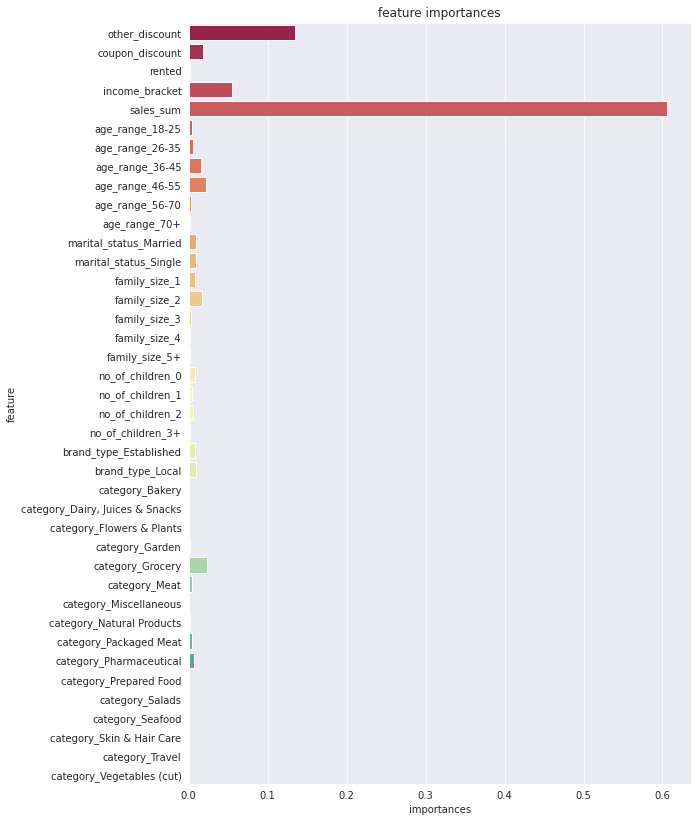

In [112]:
fig = plt.figure(figsize = (9, 14))
ax = fig.gca()
income = sns.barplot(x = "importances", y = "feature", data=feat_impts2 , ax=ax,palette = 'Spectral')
income.set_title("feature importances")
plt.show()